In [1]:
import torch
import numpy as np
import pyro
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import pyro.distributions as dist

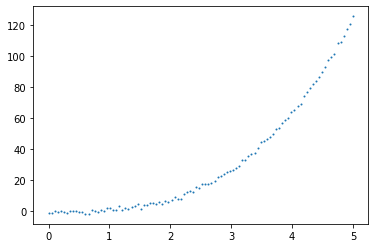

In [3]:
samples = 100
train_x = torch.linspace(0, 5, samples).float()
train_y = train_x**3 + torch.normal(torch.zeros(samples), torch.ones(samples)).float()
train_x = train_x.unsqueeze(-1)
train_y = train_y.unsqueeze(-1)

plt.scatter(train_x, train_y, s=1)

In [4]:
def model2(x, y=None):
    w1 = pyro.sample("w1", dist.Normal(torch.zeros((1, 16)), torch.ones((1, 16))).to_event(2))
    b1 = pyro.sample("b1", dist.Normal(torch.zeros(16), torch.ones(16)).to_event(1))
    x = F.relu(x @ w1 + b1)

    w2 = pyro.sample("w2", dist.Normal(torch.zeros((16, 16)), torch.ones((16, 16))).to_event(2))
    b2 = pyro.sample("b2", dist.Normal(torch.zeros(16), torch.ones(16)).to_event(1))
    x = F.relu(x @ w2 + b2)

    w3 = pyro.sample("w3", dist.Normal(torch.zeros((16, 1)), torch.ones((16, 1))).to_event(2))
    b3 = pyro.sample("b3", dist.Normal(torch.zeros(1), torch.ones(1)).to_event(1))
    x = x @ w3 + b3

    sigma = pyro.sample("sigma", dist.Uniform(0, 1))
    
    with pyro.plate("data", x.shape[0]):
        result = pyro.sample("y", dist.Normal(x, sigma).to_event(1), obs=y)

    return result

In [ ]:
pyro.clear_param_store()
kernel = pyro.infer.NUTS(model2)
mcmc = pyro.infer.MCMC(kernel, warmup_steps=100, num_samples=500, num_chains=1)
mcmc.run(train_x, train_y)
mcmc.summary()

In [21]:
pyro.get_param_store().save("trained_models/pyro_test_mcmc.save")

In [7]:
pyro.get_param_store().load("trained_models/pyro_test_mcmc.save")

In [43]:
from tqdm.auto import trange

guide = pyro.infer.autoguide.AutoDiagonalNormal(model2)
optimizer = pyro.optim.Adam({"lr": 1e-3})
svi = pyro.infer.SVI(model2, guide, optimizer, loss=pyro.infer.Trace_ELBO())

bar = trange(2000)
pyro.clear_param_store()
for epoch in bar:
    loss = svi.step(train_x, train_y)
    bar.set_postfix(loss=f"{loss / train_x.shape[0]}")

    

100%|██████████| 2000/2000 [00:24<00:00, 81.71it/s, loss=54.81629966616631] 


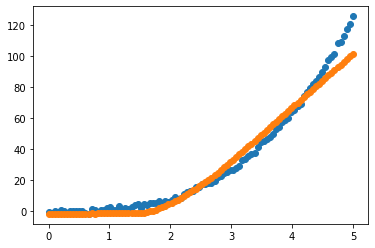

In [44]:
plt.scatter(train_x, train_y)
predictive = pyro.infer.Predictive(model2, guide=guide, num_samples=500)
posterior_samples = predictive(train_x)["y"]
#posterior_samples = torch.stack([guide(train_x) for _ in range(100)])
plt.scatter(train_x, posterior_samples.mean(dim=0))

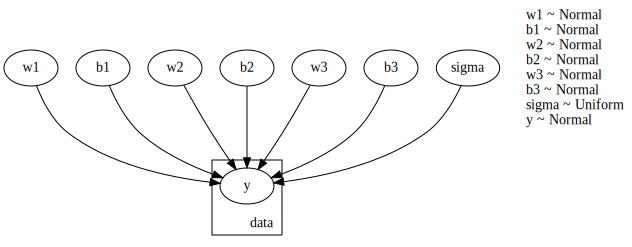

In [13]:
pyro.render_model(model2, model_args=(train_x,), render_distributions=True)

In [38]:
import torch.nn as nn

mle_model = nn.Sequential(nn.Linear(1, 16), nn.ReLU(), nn.Linear(16, 16), nn.ReLU(), nn.Linear(16, 1))
mle_optim = torch.optim.Adam(mle_model.parameters(), lr=1e-3)
mle_bar = trange(200)
for epoch in mle_bar:
    epoch_loss = torch.tensor(0, dtype=torch.float)
    for i in range(0, train_x.shape[0], 2):
        mle_optim.zero_grad()
        xs = train_x[i:i+2]
        ys = train_y[i:i+2]
        output = mle_model(xs)
        loss = torch.nn.functional.mse_loss(output, ys)
        loss.backward()
        mle_optim.step()
        epoch_loss += loss
    bar.set_postfix(loss=f"{epoch_loss / (2 * train_x.shape[0])}")


100%|██████████| 200/200 [00:08<00:00, 24.00it/s]


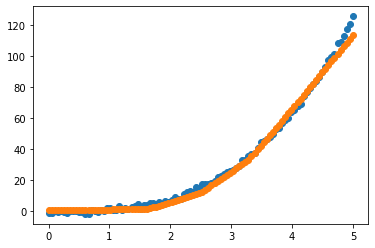

In [40]:
plt.scatter(train_x, train_y)
plt.scatter(train_x, mle_model(train_x).detach())